In [1]:
from Bio import SeqIO
import subprocess
from io import StringIO

In [2]:
from Bio import Entrez, SeqIO

Entrez.email = 'pg52526@alunos.uminho.pt'

orfs = ['SALL3', 'RNF130', 'RIMS2']
ids = ['Q62255', 'Q86XS8', 'Q9UQ26']
# SALL3 - aminoacid sequence                  Uniprot id = Q62255
# RNF130 - aminoacid sequence                 Uniprot id = Q86XS8
# RIMS2 - SARS-CoV-2 aminoacid sequence       Uniprot id = Q9UQ26

# Fetch the gene sequence using the gene ID or name
# Save it as {gene_name}.fa or .gb
for orf, id in zip(orfs, ids):
    # FASTA
    handle = Entrez.efetch(db="Protein", id=id, rettype="fasta", retmode="text")
    record = handle.read()
    handle.close()
    with open(f"{orf}.fa", "w") as output_file:
        output_file.write(record)

    # GENBANK
    handle = Entrez.efetch(db='Protein', id=id, rettype='gb', retmode='text')
    record = handle.read()
    handle.close()
    with open(f"{orf}.gb", "w") as output_file:
        output_file.write(record)


In [3]:
from Bio.Blast import NCBIWWW, NCBIXML

# Please note that this process takes a few minutes
# Query BLAST with FASTA files
for orf in orfs:
    print("Creating " + orf + " file...")
    # Read the gene sequence from the FASTA file
    with open(f"{orf}.fa", "r") as fasta_file:
        gene_sequence = fasta_file.read()

    # Perform BLAST query against NCBI's database
    result_handle = NCBIWWW.qblast("blastp", "nr", gene_sequence, 
                                   entrez_query='human[Organism]', 
                                   hitlist_size=10)

    # Save the BLAST results in a file
    with open(f"{orf}_blast_results.xml", "w") as output_blast:
        output_blast.write(result_handle.read())

CreatingSALL3File...
CreatingRNF130File...
CreatingRIMS2File...


In [4]:
from Bio import AlignIO, Phylo
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# Find High-scoring Segment Pairs (HSP) for each orf
for orf in orfs:
    with open(f"{orf}_blast_results.xml", "r") as output_blast:
        blast_records = NCBIXML.parse(output_blast)
        sequences = []
        for record in blast_records:
            for alignment in record.alignments:
                for hsp in alignment.hsps:
                    sequences.append(hsp.sbjct)
    
    # Perform Multiple Sequence Alignment (MSA)
    alignment_file = f"{orf}_alignment.fa"
    aligned_file = f"{orf}_aligned.fa"
    with open(alignment_file, "w") as out_handle:
        for i, seq in enumerate(sequences):
            out_handle.write(f">Sequence_{i+1}\n{seq}\n")

    clustalomega_cline = ClustalOmegaCommandline("clustalo", infile=alignment_file, outfile=aligned_file, verbose=True, force=True)
    stdout, stderr = clustalomega_cline()

/home/chris/.local/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


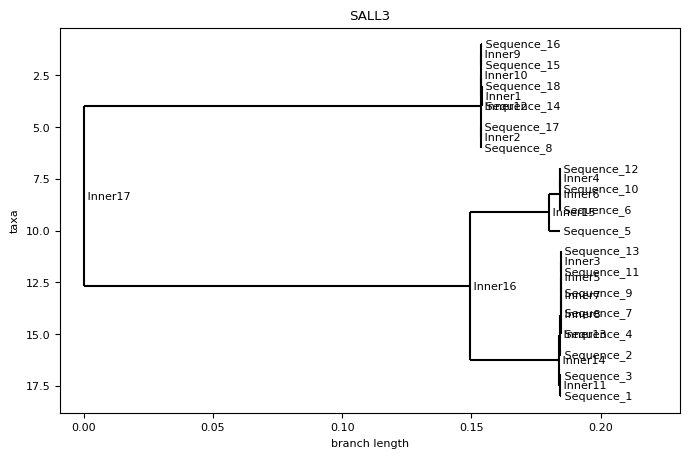

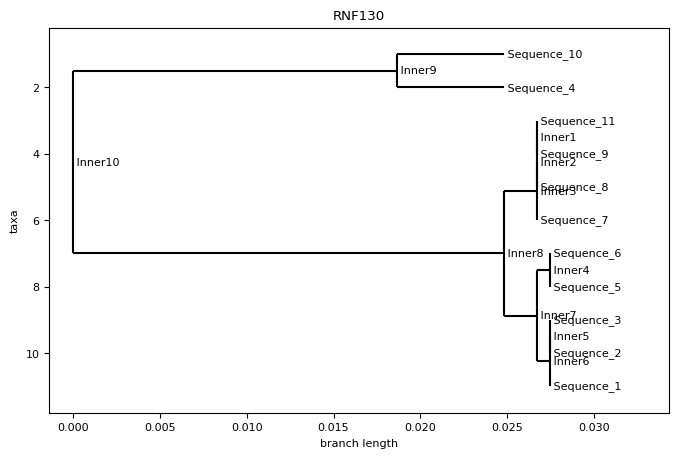

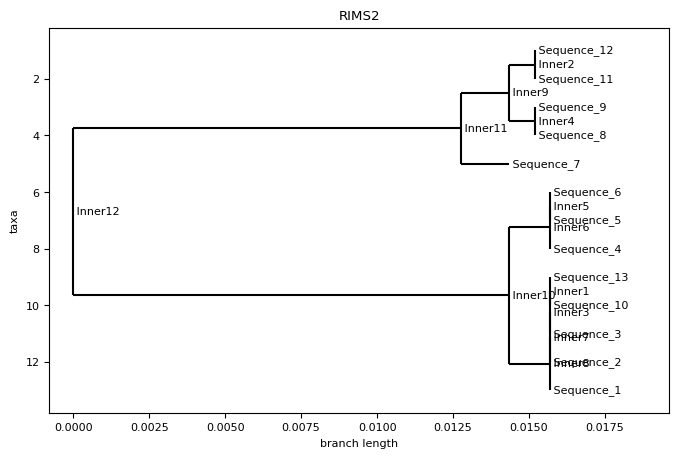

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=8)
plt.rc('figure', figsize=(8, 5))
# Read the alignment
for orf in orfs:
    alignment = AlignIO.read(f"{orf}_aligned.fa", "fasta")

    # Construct a Phylogenetic Tree
    calculator = DistanceCalculator('blastp') # Distance calculator method for proteins
    dm = calculator.get_distance(alignment)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(dm)

    # Draw or display the tree
    Phylo.draw(tree, title={'label' : orf})